## Program 2.1 (SIR model) - original Fortran code

In [1]:
%%writefile Program_2_1.f
C
C This is the FORTRAN version of program 2.1 from page 19 of
C "Modeling Infectious Disease in humans and animals"
C by Keeling & Rohani.
C 
C It is the simple SIR epidemic without births or deaths.
C
C This code is written to be simple, transparent and readily compiled.
C Far more elegant and efficient code can be written.
C
C This code can be compiled using the intel fortran compiler:
C ifort -Vaxlib  -o Program_2_1  Program_2_1.f  
C 


C Main program starts here.

      program main

      REAL beta
      REAL gamma

      REAL S,I,R

      REAL S0
      REAL I0
      REAL MaxTime
      REAL EVERY, step, t

      INTEGER GivesName

      CHARACTER*2000 str, FileName

      COMMON /parameters/ beta, gamma
      COMMON /variables/ S, I, R

      GivesName=iargc()

      if (GivesName.eq.0) then
         beta=1.4247
         gamma=0.14286
         S0=1 - 1.0d-6
         I0=1.0d-6
         MaxTime=70
      else
 
c     
c     READ IN ALL THE VARIABLES
c

         call getarg(1,FileName)

         open(1,file=FileName,STATUS='OLD',ACCESS='SEQUENTIAL')
  
         
         read(1,*) str
         read(1,*) beta
         
         read(1,*) str
         read(1,*) gamma
         
         read(1,*) str
         read(1,*) S0
         
         read(1,*) str
         read(1,*) I0
         
         read(1,*) str
         read(1,*) MaxTime 
         
         close(1)
      endif
C
C     Check all variables are OK & set up intitial conditions */
C     
      
      if ( S0.le.0) then
         write(*,*) "ERROR: Initial level of susceptibles (",S0,") is 
     .        less than or equal to zero."
         STOP
      endif

      if ( I0.le.0) then
         write(*,*) "ERROR: Initial level of infecteds (",I0,") is 
     .        less than or equal to zero."
         STOP
      endif

      if ( beta.le.0) then
         write(*,*) "ERROR: Transmission rate beta (",beta,") is 
     .        less than or equal to zero."
         STOP
      endif

      if ( gamma.le.0) then
         write(*,*) "ERROR: Recovery rate gamma (",gamma,") is 
     .        less than or equal to zero."
         STOP
      endif

      if ( MaxTime.le.0) then
         write(*,*) "ERROR: Maximum run time (",MaxTime,") is 
     .        less than or equal to zero."
         STOP
      endif

      if (S0+I0.ge.1) then
        write(*,*) "WARNING: Initial level of susceptibles+infecteds
     .        (",S0,"+",I0,"=",S0+I0,") is greater than one."
      endif

      if (beta.lt.gamma) then
        write(*,*) "WARNING: Basic reproductive ratio (R_0=",
     .        beta/gamma,") is less than one."
      endif


      S=S0
      I=I0
      R=1-S0-I0
     
C     
C     Find a suitable time-scale for outputs 
C     
      step=0.01/((beta+gamma)*S0)

      Every=1.0/((beta+gamma)*S0)
      if (Every.gt.1) then
         Every=10.0**INT(log10(Every))
      else
         Every=10.0**INT(log10(Every)-1)
      endif
      DO WHILE (MaxTime/Every.gt.10000)
         Every=Every*10.0  
      ENDDO

      open(1,recl=3000,file='Program_2_1_f.out',ACCESS='SEQUENTIAL')
C     for F77 use
C      open(1,file='Output_Risk',ACCESS='SEQUENTIAL')
C

C
C     The main iteration routine
C     

      t=0
      write(1,*) t,S,I,R
      DO WHILE (t.lt.MaxTime)
         

         CALL Runge_Kutta(step)
         
         t=t+step
         
C     If time has moved on sufficiently, output the current data
         
         if( INT(t/Every).gt.INT((t-step)/Every) ) then
            write(1,*) t,S,I,R
         endif
      
      ENDDO
      
      END
  


      SUBROUTINE Runge_Kutta(step)

      REAL InitialPop(3), tmpPop(3)
      REAL dPop1(3), dPop2(3), dPop3(3), dPop4(3)

      REAL S,I,R, step
      COMMON /variables/ S, I, R

C
C     Integrates the equations one step, using Runge-Kutta 4 
C     Note: we work with arrays rather than variables to make the
C     coding easier
C
      InitialPop(1)=S
      InitialPop(2)=I
      InitialPop(3)=R

      CALL Diff(InitialPop,dPop1)
      do k=1,3
         tmpPop(k)=InitialPop(k)+step*dPop1(k)/2.0
      ENDDO 

      CALL Diff(tmpPop,dPop2)
      do k=1,3
         tmpPop(k)=InitialPop(k)+step*dPop2(k)/2.0
      ENDDO

      CALL Diff(tmpPop,dPop3)
      do k=1,3
         tmpPop(k)=InitialPop(k)+step*dPop3(k)
      ENDDO

      CALL Diff(tmpPop,dPop4)

      do k=1,3
         tmpPop(k)=InitialPop(k)+step*(dPop1(k)/6 + dPop2(k)/3 +
     .        dPop3(k)/3 + dPop4(k)/6)
      ENDDO

      S=tmpPop(1)
      I=tmpPop(2)
      R=tmpPop(3)

      RETURN
      END


 
C The Main Differential Equations.

      SUBROUTINE Diff(Pop, dPop)

      REAL Pop(3), dPop(3)

      REAL beta
      REAL gamma

      COMMON /parameters/ beta, gamma


C     Set up temporary variables to make the equations look neater

      REAL tmpS, tmpI, tmpR

      tmpS=Pop(1)
      tmpI=Pop(2)
      tmpR=Pop(3)

C
C     The differential equations
C

C     dS/dt =
      dPop(1) = - beta*tmpS*tmpI

C     dI/dt =
      dPop(2) = beta*tmpS*tmpI - gamma*tmpI

C     dR/dt =
      dPop(3) = gamma*tmpI
      
      RETURN
      END


Overwriting Program_2_1.f


In [2]:
!gfortran -O3 -o Program_2_1_f Program_2_1.f

In [3]:
!./Program_2_1_f parameters.txt

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [5]:
sir_out = pd.read_csv("Program_2_1_f.out",sep="\s+",engine="python",header=None,names=["t","S","I","R"],index_col=False)

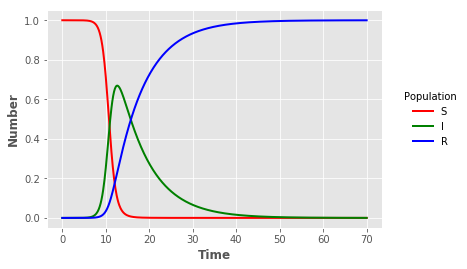

In [6]:
sline = plt.plot("t","S","",data=sir_out,color="red",linewidth=2)
iline = plt.plot("t","I","",data=sir_out,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out,color="blue",linewidth=2)
plt.xlabel("Time",fontweight="bold")
plt.ylabel("Number",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)